In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [289]:
import math
import string
import re
from datetime import datetime

In [384]:
from src.EDA import EDA

In [3]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
    mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
    
    return mz_table

In [4]:
videogames = pd.read_json('Data/meta_Video_Games.json', lines=True)
reviews = pd.read_json('Data/Video_Games.json', lines=True)

## Cleaning Video Games DF

In [129]:
#drop also_buy, also_view, date, details, similar_item, tech1, tech2
main_videogames = videogames.copy()
main_videogames.drop(columns=['also_buy', 'also_view', 'date', 'details', 'similar_item', 'tech1', 'tech2'], inplace=True)

In [130]:
# #Check for missing values #1
# missing_zero_values_table(main_videogames)

### Changing missing title names to their actual titles

In [131]:
indexes = [467, 11873, 11876, 11878, 13376, 24782, 24785, 24787, 29674, 38379, 52373, 61916, 63263, 64453]
title_names = ['Dune 2000', 'Virtual Stick Pro', 'Saturn Control Pad Mist Gray', 'Saturn control pad', 'Dune 2000', 
               'Virtual Stick Pro', 'Saturn Control Pad Mist Gray', 'Saturn control pad', 'Sega Vertual Stick', 'Puppet Motel',
               'Friendship Collection New Life','Ranch Story Connected New World', 'Kirby Triple Deluxe', 'Detective Conan Phantom Rhapsody']

In [132]:
for idx, val in enumerate(indexes):
    main_videogames.loc[val, 'title'] = title_names[idx]

In [133]:
# #Check for missing values #2
# missing_zero_values_table(main_videogames)

In [134]:
float_puncs = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
str1=""

def remove_puncs_into_floats(item):
    table = str.maketrans('','', float_puncs)
    stripped = [i.translate(table) for i in item]
    return float(str1.join(stripped))

#change missing prices to -1, and change string prices to floats
prices = main_videogames.price.apply(lambda x: float(-1) if isinstance(x, float) else remove_puncs_into_floats(x))

In [135]:
#Since 81.7% of prices are missing, and not doing a recommender based on price, remove price column.
#Since images are not being used to create a recommender, remove image column.
main_videogames.drop(columns=['price','image'],inplace=True)

In [136]:
# #Check for missing values #3
# missing_zero_values_table(main_videogames)

In [137]:
def remove_puncs(item):
    table = str.maketrans('','', float_puncs)
    stripped = [i.translate(table) for i in item]
    return str1.join(stripped)

In [138]:
#converting rank strings to just rank numbers
rank = main_videogames["rank"].apply(lambda x: "999999999" if isinstance(x, float) else remove_puncs(x).split(" ",1)[0])

In [139]:
rank = rank.apply(lambda x: x.split("i", 1)[0])

In [140]:
#find messed up values in rnak #4
for idx, val in enumerate(rank):
    if val == 'productDescr':
        print(idx)

52316


In [141]:
rank[52316] = 999999999

In [142]:
rank = rank.apply(lambda x: float(x))

In [143]:
main_videogames['rank']=rank

In [144]:
# #Check for missing values #4
# missing_zero_values_table(main_videogames)

In [145]:
#Change all nulls in main_cat into 'Video Games'
main_cat = main_videogames['main_cat'].apply(lambda x: 'Video Games' if isinstance(x, float) else x)
main_videogames['main_cat'] = main_cat

#Change all nulls in features into 'no_features'
features = main_videogames['feature'].apply(lambda x: 'no_features' if isinstance(x, float) else x)
main_videogames['feature'] = features

#Change all null in description into 'no_description'
description = main_videogames['description'].apply(lambda x: 'no_description' if isinstance(x, float) else x)
main_videogames['description'] = description

In [146]:
# #Check for missing values #5
# missing_zero_values_table(main_videogames)

In [147]:
#Change null brands to 'no_brand'
brand = main_videogames['brand'].apply(lambda x: 'no_brand' if isinstance(x, float) else x)

#Remove html taggings "by\n \n"
filter_tag = 'by\n    \n    '
brand = brand.apply(lambda x: x[12:] if filter_tag in x else x)
main_videogames['brand'] = brand

#Change null category to ['Video Games']
category = main_videogames['category'].apply(lambda x: ['Video Games'] if isinstance(x, float) else x)
main_videogames['category'] = category

In [148]:
#Check for missing values #6
missing_zero_values_table(main_videogames)

Your selected dataframe has 8 columns and 84893 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [149]:
#Change category into a full string
str2 = " "
category = main_videogames['category'].apply(lambda x: str2.join(x) if isinstance(x, list) else x)
main_videogames['category'] = category

#Change description into a full string
description = main_videogames['description'].apply(lambda x: str2.join(x) if x!='no_description' else x)
main_videogames['description'] = description

#Change feature into a full string
feature = main_videogames['feature'].apply(lambda x: str2.join(x) if x!='no_features' else x)
main_videogames['feature'] = feature

In [150]:
#manually change categories to their sub category
category = main_videogames['category'].apply(lambda x: x[12:] if x!='Video Games' else x)
category = category.apply(lambda x: x[len('Retro Gaming & Microconsoles '):] if 'Retro Gaming & Microconsoles ' in x else x)
main_videogames['category'] = category

#drop main_cat
main_videogames.drop('main_cat', 1, inplace=True)

## Save to new csv file

In [168]:
main_videogames.to_csv('Data/main_videogames.csv')

## Copy to test filling out descriptions and features

In [329]:
#makes a copy
full_videogames = main_videogames.copy()

In [330]:
#too many different categories. removing excessive details
category = full_videogames['category'].apply(lambda x: x.split("  ")[0].strip() if len(x.split("  "))>1 else x.strip())
full_videogames['category'] = category

In [331]:
#using excessive details from long categories to fill in empty descriptions and featuers
description_feature = full_videogames['category'].apply(lambda x: x.split("  ")[1].strip() if len(x.split("  "))>1 else x.strip())
descriptions = []
features = []

for idx, val in enumerate(full_videogames['description']):
    if val == 'no_description':
        descriptions.append(description_feature[idx])
    else:
        descriptions.append(val)

for idx, val in enumerate(full_videogames['feature']):
    if val == 'no_features':
        features.append(description_feature[idx])
    else:
        features.append(val)

full_videogames['description'] = descriptions
full_videogames['feature'] = features

In [341]:
# sorted(full_videogames.category.unique())

['',
 '3DO',
 '3DO Accessories',
 '3DO Consoles',
 '3DO Games',
 '4-player simultaneous play Greater distinction between characters than TMNT 1 2 modes of play',
 'Accessories',
 'Accessories Added protection for your Wii Remote, non-slip material Easy access to all buttons and ports, for both the Nunchuk and Wii Remote Designed to form fit your Wii Remote perfectly while adding grip Made of high grade quality silicone with an exact mold of your Wii Remote Add color to each players remote!',
 "Accessories Carry your Nintendo DSi and accessories with this Airform EVA Carrying Case. Stylish EVA material protects your DSi. Pocket slots inside to carry your game cartridges, an extra stylus and other stuff. Inside lined with microfiber. Elastic strap to hold the DS Lite so it doesn't fall out when you open the case. Comes with a lanyard strap. Suitable for Nintendo DSi, also suitable for Nintendo Ds Lite. Come with a hand strap to carry your dsi easier.",
 'Accessories Multi-Function Charge

In [366]:
def platform_type(item):
    if '3DO' in item: return '3DO'
    elif 'Atari 2600' in item: return 'Atari 2600'
    elif 'Atari 5200' in item: return 'Atari 5200'
    elif 'Atari 7800' in item: return 'Atari 7800'
    elif 'Atari Jaguar' in item: return 'Atari Jaguar'
    elif 'Atari Lynx' in item: return 'Atari Lynx'
    elif 'ColecoVision' in item: return 'ColecoVision'
    elif 'Commodore 64' in item: return 'Commodore 64'
    elif 'Commodore Amiga' in item: return 'Commodore Amiga'
    elif 'Mac' in item: return 'Mac'
    elif 'PC' in item: return 'PC'
    elif 'Intellivision' in item: return 'Intellivision'
    elif 'Nintendo DS' in item: return 'Nintendo DS'
    elif 'Nintendo 64' in item: return 'Nintendo 64'
    elif 'Nintendo 3DS' in item: return 'Nintendo 3DS'
    elif 'Nintendo Switch' in item: return 'Nintendo Switch'
    elif 'PlayStation 2' in item: return 'PlayStation 2'
    elif 'PlayStation 3' in item: return 'PlayStation 3'
    elif 'PlayStation 4' in item: return 'PlayStation 4'
    elif 'PlayStation Vita' in item: return 'PlayStation Vita'
    elif 'PlayStation' in item: return 'PlayStation'
    elif 'PSP' in item: return 'PSP'
    elif 'Wii U' in item: return 'Wii U'
    elif 'Wii' in item: return 'Wii'
    elif 'Xbox 360' in item: return 'Xbox 360'
    elif 'Xbox One' in item: return 'Xbox One'
    elif 'Xbox' in item: return 'Xbox'
    elif 'Linux' in item: return 'Linux'
    elif 'NEOGEO Pocket' in item: return 'NEOGEO Pocket'
    elif 'NES' in item: return 'NES'
    elif 'Ouya' in item: return 'Ouya'
    elif 'Virtual Reality' in item: return 'Virtual Reality'
    elif 'Retro Gaming & Microconsoles' in item: return 'Retro Gaming & Microconsoles'
    elif 'Sega CD' in item: return 'Sega CD'
    elif 'Sega Dreamcast' in item: return 'Sega Dreamcast'
    elif 'Sega Game Gear' in item: return 'Sega Game Gear'
    elif 'Sega Genesis' in item: return 'Sega Genesis'
    elif 'Sega Master System' in item: return 'Sega Master System'
    elif 'Sega Saturn' in item: return 'Sega Saturn'
    elif 'Super Nintendo' in item: return 'Super Nintendo'
    elif 'TurboGrafx 16' in item: return 'TurboGrafx 16'
    elif 'GameCube' in item: return 'GameCube'
    elif 'Game Boy Advance' in item: return 'Game Boy Advance'
    elif 'Game Boy Color' in item: return 'Game Boy Color'
    elif 'Game Boy' or 'Game boy' in item: return 'Game Boy'
    else: return 'none'

In [367]:
def product_type(item):
    if 'Games' in item: return 'Game'
    elif 'Controller' in item: return 'Controller'
    elif 'Joysticks' in item: return 'Joystick'
    elif 'Racing Wheel' in item: return 'Racing Wheel'
    elif 'Gamepads' in item: return 'Gamepads'
    elif 'Consoles' in item: return 'Console'
    elif 'Cables' in item: return 'Cables'
    elif 'System' in item: return 'System'
    elif 'Batteries' in item: return 'System'
    elif 'Headset' in item: return 'Headset'
    elif 'DLC' in item: return 'DLC'
    elif 'Figures' in item: return 'Figures'    
    elif 'Mounts' or 'Brackets' or 'Stands' in item: return 'Mounts'    
    elif 'Subscription' in item: return 'Subscription'
    elif 'Accessories' in item: return 'Accessories'

In [370]:
#Get the platform and product type of each item
platform = full_videogames['category'].apply(lambda x: platform_type(x))
product = full_videogames['category'].apply(lambda x: product_type(x))

full_videogames['platform'] = platform
full_videogames['product'] = product

In [ ]:
#TODO: Include average rating of items

## Videogames EDA

In [376]:
eda = EDA()

In [381]:
?eda #update docstring

Object `eda #update docstring` not found.


NameError: name 'autolabel' is not defined

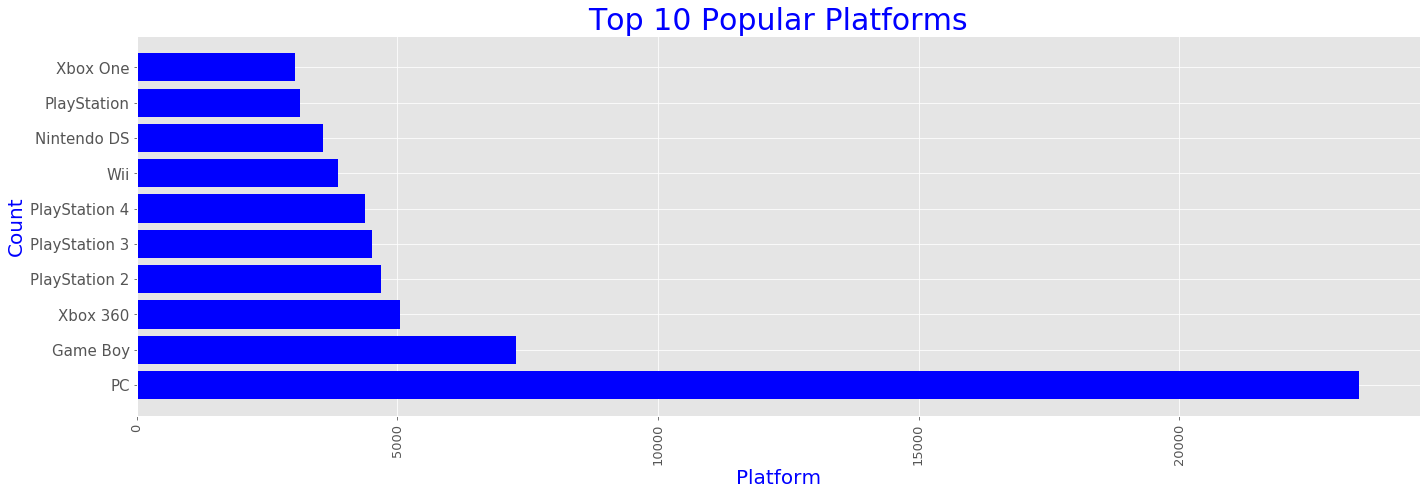

In [385]:
#1. Top 10 Platforms BarH
platform_counts = full_videogames['platform'].value_counts()
platform_list = []
count_list = []

for key, val in platform_counts.items():
    platform_list.append(str(key))
    count_list.append(val)

#plot here
eda.print_bar(platform_list[:10], count_list[:10], x_label='Platform', y_label='Count', 
              title='Top 10 Popular Platforms', orientation='hort')

In [ ]:
#2. Top 10 Brand BarH
brand_counts = full_videogames['brand'].value_counts()
brand_list = []
count_list = []

for key, val in brand_counts.items():
    brand_list.append(str(key))
    count_list.append(val)
    
#plot here

In [ ]:
#3. Top 10 Product Type BarH
product_counts = full_videogames['product'].value_counts()
product_list = []
count_list = []

for key, val in product_counts.items():
    product_list.append(str(key))
    count_list.append(val)
    
#plot here

In [312]:
full_videogames['brand'].value_counts()

no_brand                    4030
Nintendo                    3429
Electronic Arts             3251
Activision                  2799
Sega                        2207
                            ... 
VRunow                         1
Codemasters Software Co.       1
Studio Black Flag              1
Flash                          1
Decrescent                     1
Name: brand, Length: 7780, dtype: int64

In [310]:
full_videogames.head()

,category,title,brand,rank,asin,description,feature,platform,product
0,PC Games,Reversi Sensory Challenger,Fidelity Electronics,2623937.0,0042000742,PC Games,PC Games,PC,Game
1,Xbox 360 Games,Medal of Honor: Warfighter - Includes Battlefi...,EA Games,67231.0,0078764343,Brand new sealed!,Xbox 360 Games,Game Boy,Game
2,Super Nintendo Games,street fighter 2 II turbo super nintendo snes ...,Nintendo,134433.0,0276425316,Super Nintendo Games,Super Nintendo Games,Game Boy,Game
3,Xbox 360 Accessories Controllers Joysticks,Xbox 360 MAS STICK,MAS SYSTEMS,105263.0,0324411812,MAS's Pro Xbox 360 Stick (Perfect 360 Stick) S...,Original PCB used from Xbox 360 Control Pad (t...,Game Boy,Controller
4,PC Games,Phonics Alive! 3: The Speller,Advanced Software Pty. Ltd.,92397.0,0439335310,"Phonics Alive! 3, The Speller teaches students...",Grades 2-12 Spelling Program Teaches Spelling ...,PC,Game


In [241]:
#Save to new CSV
full_videogames.to_csv('Data/full_videogames.csv')

### Copy dataframe, then start Shrinking to unique values

In [243]:
simple_videogames = full_videogames.copy()

In [245]:
simple_videogames.drop('category', 1, inplace=True)

In [256]:
description = simple_videogames['title'] + ' ' + simple_videogames['brand'] + ' ' + simple_videogames['description'] + ' ' + simple_videogames['feature'] + ' ' + simple_videogames['platform'] + ' ' + simple_videogames['product']

In [258]:
simple_videogames.drop(columns = ['title','brand','feature','platform','product'], inplace=True)
simple_videogames['description'] = description

In [259]:
simple_videogames.head()
#would we want to have unique words in the description? or keep nuber of words 

,rank,asin,description
0,2623937.0,0042000742,Reversi Sensory Challenger Fidelity Electronic...
1,67231.0,0078764343,Medal of Honor: Warfighter - Includes Battlefi...
2,134433.0,0276425316,street fighter 2 II turbo super nintendo snes ...
3,105263.0,0324411812,Xbox 360 MAS STICK MAS SYSTEMS MAS's Pro Xbox ...
4,92397.0,0439335310,Phonics Alive! 3: The Speller Advanced Softwar...


# Cleaning Reviews DF

In [261]:
#change image to 0 or 1
main_reviews = reviews.copy()
image = [0 if isinstance(i,float) else 1 for i in main_reviews.image]
main_reviews['image'] = image

In [262]:
#drop columns = reviewTime, reviewName, style, vote
main_reviews.drop(columns=['reviewTime', 'reviewerName', 'style', 'vote'], inplace=True)

### Handle Missing

In [263]:
missing_zero_values_table(main_reviews)

Your selected dataframe has 8 columns and 2565349 Rows.
There are 2 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
reviewText,0,1715,0.1,1715,0.1,object
summary,0,811,0.0,811,0.0,object


In [264]:
np.unique(reviews.reviewText.isna(), return_counts=True)

(array([False,  True]), array([2563634,    1715]))

In [265]:
np.unique(reviews.summary.isna(), return_counts=True)

(array([False,  True]), array([2564538,     811]))

In [266]:
reviewText = main_reviews.reviewText.apply(lambda x: 'no_text_was_given' if isinstance(x, float) else x)

In [267]:
summary = main_reviews.summary.apply(lambda x: 'no_summary_given' if isinstance(x, float) else x)

In [268]:
main_reviews['reviewText'] = reviewText
main_reviews['summary'] = summary

In [269]:
missing_zero_values_table(main_reviews)

Your selected dataframe has 8 columns and 2565349 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [282]:
#change verified values to 0 or 1
verified = main_reviews['verified'].apply(lambda x: 1 if x==True else 0)
main_reviews['verified'] = verified

In [300]:
#change unixReviewTime to corresponding day/week/month/year
ReviewTime = pd.Timestamp(main_reviews['unixReviewTime'][0], unit='s')
day = ReviewTime.dayofyear
week = ReviewTime.weekofyear
month = ReviewTime.month
year = ReviewTime.year

main_reviews['day'] = day
main_reviews['week'] = week
main_reviews['month'] = month
main_reviews['year'] = year

In [301]:
#Save dataframe to CSV
main_reviews.to_csv('Data/main_reviews.csv')

## EDA on Reviews

In [ ]:
#1. Barplot on ratings given




In [ ]:
#2. Verified vs Nonverified



##### Done Cleaning Reviews DF

## Copy main_reviews for count vectorizer

In [303]:
simple_reviews = main_reviews.copy()

In [304]:
simple_reviews.drop(columns=['verified','unixReviewTime','image','day','week','month','year'], inplace=True)

In [306]:
reviewText = simple_reviews['reviewText'] + ' ' + simple_reviews['summary']

In [308]:
simple_reviews['reviewText'] = reviewText
simple_reviews.drop('summary', 1, inplace=True)

In [309]:
simple_reviews.head()

,overall,reviewerID,asin,reviewText
0,1,A21ROB4YDOZA5P,0439381673,I used to play this game years ago and loved i...
1,3,A3TNZ2Q5E7HTHD,0439381673,The game itself worked great but the story lin...
2,4,A1OKRM3QFEATQO,0439381673,I had to learn the hard way after ordering thi...
3,1,A2XO1JFCNEYV3T,0439381673,The product description should state this clea...
4,4,A19WLPIRHD15TH,0439381673,I would recommend this learning game for anyon...
